<a href="https://colab.research.google.com/github/mrdobson/SENSIP_2021_REU/blob/main/jpnb/mnist_qnn_2class_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit
!pip install qiskit_machine_learning
!pip install pylatexenc

This program is designed to perform training of a Quantum Neural Network on the MNIST dataset, two elements at a time. It will classify two labels (digits) against each other in a looping fashion.

To enable GPU acceleration (still needs some work) set the gpu parameter to 'True'. Otherwise, run as-is. Several quantum circuit implementations are still early and not working well in current (06/23/2021) version.

In [ ]:
# not all of these are critical, but to be safe just including everything for now
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import qiskit

from torch import tensor
from torch import cat, no_grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss, CrossEntropyLoss,
                      MaxPool2d, Flatten, Sequential, ReLU)
import torch.optim as optim
import torch.nn.functional as F

from torchsummary import summary

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, ADAM

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix

In [ ]:
qi_qasm = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=1024)
qi_sv = QuantumInstance(Aer.get_backend('statevector_simulator'))

# select whether to run on GPU or not
gpu = False

# predefine number of epochs to train over
epochs = 7

# if use_cuda == true then use GPU accel functions
use_cuda = torch.cuda.is_available()

print('CUDA available:', use_cuda)

if use_cuda and gpu:
    device = torch.device('cuda')
    print('Training on GPU...')
else:
    device = torch.device('cpu')
    print('Training on CPU...')

CUDA available: False
Training on CPU...


In [ ]:
# full data set range
data_set = list(range(0,10))
print(data_set)

QC_outputs = ['000', '001', '010', '011', '100', '101', '110', '111']

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


# Quantum Circuit Options

In [ ]:
# This guy PROBABLY shouldn't be called QuantumCircuit, because qiskit has a
# QuantumCircuit object built already, probably going to remove or rework
"""
class QuantumCircuit:

    #This class provides a simple interface for interaction 
    #with the quantum circuit 
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
                
            
        self.theta_0 = qiskit.circuit.Parameter('theta0')
        self.theta_1 = qiskit.circuit.Parameter('theta1')
        self.theta_2 = qiskit.circuit.Parameter('theta2')
        self.theta_3 = qiskit.circuit.Parameter('theta3')
        self.theta_4 = qiskit.circuit.Parameter('theta4')
        self.theta_5 = qiskit.circuit.Parameter('theta5')
        self.theta_6 = qiskit.circuit.Parameter('theta6')

        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta_0, all_qubits)
        self._circuit.cz(0,1)
        self._circuit.cz(1,2)
        self._circuit.ry(self.theta_1, 0)
        self._circuit.ry(self.theta_2, 1)
        self._circuit.ry(self.theta_3, 2)
        self._circuit.cz(0,1)
        self._circuit.cz(1,2)
        self._circuit.ry(self.theta_4, 0)
        self._circuit.ry(self.theta_5, 1)
        self._circuit.ry(self.theta_6, 2)

        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        job = qiskit.execute(self._circuit, 
                             self.backend, 
                             shots = self.shots,
                             parameter_binds = [{self.theta_0: thetas[0],
                                                 self.theta_1: thetas[1],
                                                 self.theta_2: thetas[2],
                                                 self.theta_3: thetas[3],
                                                 self.theta_4: thetas[4],
                                                 self.theta_5: thetas[5],
                                                 self.theta_6: thetas[6],}])
        counts = job.result().get_counts(self._circuit)
        
        expects = np.zeros(8)
        for k in range(8):
            key = QC_outputs[k]
            perc = counts.get(key, 0) /self.shots
            expects[k] = perc
        
        return expects
"""

"\nclass QuantumCircuit:\n\n    #This class provides a simple interface for interaction \n    #with the quantum circuit \n    \n    def __init__(self, n_qubits, backend, shots):\n        # --- Circuit definition ---\n        self._circuit = QuantumCircuit(n_qubits)\n        \n        all_qubits = [i for i in range(n_qubits)]\n                \n            \n        self.theta_0 = qiskit.circuit.Parameter('theta0')\n        self.theta_1 = qiskit.circuit.Parameter('theta1')\n        self.theta_2 = qiskit.circuit.Parameter('theta2')\n        self.theta_3 = qiskit.circuit.Parameter('theta3')\n        self.theta_4 = qiskit.circuit.Parameter('theta4')\n        self.theta_5 = qiskit.circuit.Parameter('theta5')\n        self.theta_6 = qiskit.circuit.Parameter('theta6')\n\n        \n        self._circuit.h(all_qubits)\n        self._circuit.barrier()\n        self._circuit.ry(self.theta_0, all_qubits)\n        self._circuit.cz(0,1)\n        self._circuit.cz(1,2)\n        self._circuit.ry(self.t

In [ ]:
class BellCirc(QuantumCircuit):
    def __init__(self, backend, shots, n_qubits=2):
        # circuit definition
        # qiskit QuantumCircuit object takes args num qubits, num classical registers
        self._circuit = QuantumCircuit(n_qubits, n_qubits)

        self.theta_0 = qiskit.circuit.Parameter('theta0')
        self.theta_1 = qiskit.circuit.Parameter('theta1')

        self._circuit.h(0)
        self._circuit.cx(0, 1)
        self._circuit.barrier()
        self._circuit.ry(self.theta_0, 0)
        self._circuit.ry(self.theta_1, 1)
        self._circuit.barrier()
        self._circuit.cx(0, 1)
        self._circuit.h(0)

        self._circuit.measure(0, 0)

        self.backend = backend
        self.shots = shots
      
    def run(self, thetas):
        job = qiskit.execute(self._circuit,
                             self.backend,
                             shots = self.shots,
                             parameter_binds = [{self.theta_0: thetas[0],
                                                 self.theta_1: thetas[1]}])
        counts = job.result().get_counts(self._circuit)

        expects = np.zeros(2)
        for k in range(2):
            key = QC_outputs[k]
            perc = counts.get(key, 0) /self.shots
            expects[k] = perc

        return expects

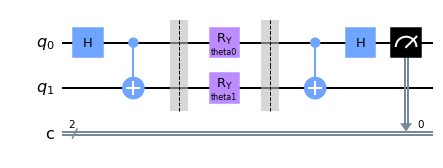

In [ ]:
# validate bell circuit
qc1 = BellCirc(qi_qasm, 100, 2)
qc1._circuit.draw('mpl')

# Data Loaders

In [ ]:
# training data load function
def load_training(val_1=0, val_2=1, n_samples=70):
    # returns tuple with X_train.data and X_train.targets <-- what I don't have from iris
    X_train = datasets.MNIST(root='./data', train=True, download=True,
                             transform=transforms.Compose([transforms.ToTensor()]))

    # leave only labels samp_val_1 and samp_val_2
    idx = np.append(np.where(X_train.targets == val_1)[0][:n_samples],
                    np.where(X_train.targets == val_2)[0][:n_samples])

    X_train.data = X_train.data[idx]
    X_train.targets = X_train.targets[idx]

    # samp vals tunable above in the settings, this is to fit to our data loader
    X_train.targets[X_train.targets==val_1] = 0
    X_train.targets[X_train.targets==val_2] = 1
    ### DEBUG vnv that we remapped the correct samples 
    #print("xtrain targets ", X_train.targets, "\n")

    # perform training load
    train_loader = DataLoader(X_train, batch_size=1, shuffle=True)

    # return loader
    return train_loader


In [ ]:
# testing data load function
def load_testing(val_1=0, val_2=1, n_samples=30):
    X_test = datasets.MNIST(root='./data', train=False, download=True,
                            transform=transforms.Compose([transforms.ToTensor()]))
    # selecting which samples to keep (first 100 0s and 1s)
    idx = np.append(np.where(X_test.targets == val_1)[0][:n_samples], 
                    np.where(X_test.targets == val_2)[0][:n_samples])

    X_test.data = X_test.data[idx]
    X_test.targets = X_test.targets[idx]

    # samp vals tunable above in the settings, to fit to data loader
    X_test.targets[X_test.targets==val_1] = 0
    X_test.targets[X_test.targets==val_2] = 1
    ### DEBUG    
    #print("xtest targets ", X_train.targets, "\n")

    # perform testing load
    test_loader = DataLoader(X_test, batch_size=1, shuffle=True)

    # return loader
    return test_loader


# CPU Functions

In [ ]:
# function to perform model training
def perform_training(model, optimizer, loss_func, train_loader, val_1=0, val_2=1, epochs=5):
    # start training timer
    start_train = time.time()

    loss_list = [] # store loss history
    model.train()  # place model in training mode
    print('\nBegin training for samples {0} and {1}:'.format(val_1, val_2))

    for epoch in range(epochs):
        print('Starting epoch {} for 2 qubits'.format(epoch))
        total_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad(set_to_none=True) # init gradient
            output = model(data)             # forward pass
            ### DEBUG
            #print("target is: ", target)
            #print("output is: ", output)
            loss = loss_func(output, target) # calc loss
            loss.backward()                  # backward pass
            optimizer.step()                 # optimize weights
            total_loss.append(loss.item())   # store loss
        loss_list.append(sum(total_loss)/len(total_loss))
        print('Training [{:0f}%]\tLoss: {:.4f}'.format(
              100. * (epoch + 1) / epochs, loss_list[-1]))
        
    # finish training timer, report training runtime
    end_train = time.time()
    print('Training runtime is: ', (end_train - start_train)/60, ' min')
        
    # plot results of cost reduction
    plt.figure()
    plt.plot(loss_list)
    plt.title('Cost Reduction for 2 qubits between {0} and {1}:'.format(val_1, val_2))
    plt.xlabel('Training Iterations ({0} epochs)'.format(epochs))
    plt.ylabel('Cross Entropy Loss')
    plt.show()

    return total_loss

In [ ]:
# function to test and evaluate model
def perform_eval(model, loss_func, test_loader, total_loss, val_1=0, val_2=1):
    # start eval time
    start_eval = time.time()

    model.eval() # set into eval mode
    print('Begin eval for samples {0} and {1}:'.format(val_1, val_2))

    with no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            if len(output.shape) == 1:
                output = output.reshape(1, *output.shape)
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        
            loss = loss_func(output, target)
            total_loss.append(loss.item())
        # batch_size goes where the 1 is here
        print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'
              .format(sum(total_loss) / len(total_loss),
              correct / len(test_loader) / 1 * 100))

    # commenting this out because it reports it at a strange time in the console
    # cool visual, but doesn't work as expected, maybe put into a different function?
    """    
    # show handful of examples for 2 qubit system
    n_samples_show = 6
    count = 0
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

    model.eval()
    with no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            if count == n_samples_show:
                break
            output = model(data)
        
            pred = output.argmax(dim=1, keepdim=True) 
        
            # remap class values to samp_val 1 and 2
            # where pred == 0 set it to samp_val_1, same for pred == 1
            # below lines don't work for this, need to figure out another way but not critical
            #pred.item[pred.item()==0] = samp_val_1
            #pred.item[pred.item()==1] = samp_val_2

            axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')
            axes[count].set_xticks([])
            axes[count].set_yticks([])
            axes[count].set_title('Predicted {}'.format(pred.item()))
        
            count += 1    
    """  
    
    # end eval time
    end_eval = time.time()
    print('Evaluation time is: ', (end_eval - start_eval)/60, ' min')

# GPU Functions

In [ ]:
def perform_training_gpu(model, optimizer, loss_func, train_loader, val_1=0, val_2=1, epochs=5):
    # start training timer
    start_train = time.time()

    loss_list = [] # store loss history
    model.train()  # place model in training mode
    print('\nBegin training for samples {0} and {1}:'.format(val_1, val_2))

    for epoch in range(epochs):
        print('Starting epoch {} for 2 qubits'.format(epoch))
        total_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad(set_to_none=True) # init gradient

            # gpu optimize data and target tensors
            data = data.cuda()
            target = target.cuda()

            output = model(data).cuda()             # forward pass
            ### DEBUG
            #print("target is: ", target)
            #print("output is: ", output)
            
            loss = loss_func(output, target) # calc loss
            loss.backward()                  # backward pass
            optimizer.step()                 # optimize weights
            total_loss.append(loss.item())   # store loss
        loss_list.append(sum(total_loss)/len(total_loss))
        print('Training [{:0f}%]\tLoss: {:.4f}'.format(
              100. * (epoch + 1) / epochs, loss_list[-1]))
        
    # finish training timer, report training runtime
    end_train = time.time()
    print('Training runtime is: ', (end_train - start_train)/60, ' min')
        
    # plot results of cost reduction
    plt.figure()
    plt.plot(loss_list)
    plt.title('Cost Reduction for 2 qubits between {0} and {1}:'.format(val_1, val_2))
    plt.xlabel('Training Iterations ({0} epochs)'.format(epochs))
    plt.ylabel('Cross Entropy Loss')
    plt.show()

    return total_loss

In [ ]:
# function to test and evaluate model
def perform_eval_gpu(model, loss_func, test_loader, total_loss, val_1=0, val_2=1):
    # start eval time
    start_eval = time.time()

    model.eval() # set into eval mode
    print('Begin eval for samples {0} and {1}:'.format(val_1, val_2))

    with no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):

            # optimize for gpu acceleration
            data = data.cuda()
            target = target.cuda()

            output = model(data).cuda()

            if len(output.shape) == 1:
                output = output.reshape(1, *output.shape)
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        
            loss = loss_func(output, target)
            total_loss.append(loss.item())
        # batch_size goes where the 1 is here
        print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'
              .format(sum(total_loss) / len(total_loss),
              correct / len(test_loader) / 1 * 100))

    # commenting this out because it reports it at a strange time in the console
    # cool visual, but doesn't work as expected, maybe put into a different function?
    """    
    # show handful of examples for 2 qubit system
    n_samples_show = 6
    count = 0
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

    model.eval()
    with no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            if count == n_samples_show:
                break
            output = model(data)
        
            pred = output.argmax(dim=1, keepdim=True) 
        
            # remap class values to samp_val 1 and 2
            # where pred == 0 set it to samp_val_1, same for pred == 1
            # below lines don't work for this, need to figure out another way but not critical
            #pred.item[pred.item()==0] = samp_val_1
            #pred.item[pred.item()==1] = samp_val_2

            axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')
            axes[count].set_xticks([])
            axes[count].set_yticks([])
            axes[count].set_title('Predicted {}'.format(pred.item()))
        
            count += 1    
    """

    # end eval time
    end_eval = time.time()
    print('Evaluation time is: ', (end_eval - start_eval)/60, ' min')

# Alternative QNN Circuit Declarations

In [ ]:
# these are mostly unused presently
"""Initializes the Opflow Quantum Neural Network.
Args:
    operator: The parametrized operator that represents the neural network.
    input_params: The operator parameters that correspond to the input of the network.
    weight_params: The operator parameters that correspond to the trainable weights.
    exp_val: The Expected Value converter to be used for the operator.
    gradient: The Gradient converter to be used for the operator's backward pass.
    quantum_instance: The quantum instance to evaluate the network.
    input_gradients: Determines whether to compute gradients with respect to input data.
"""
"""
params1 = [Parameter('input1'), Parameter('weight1')]
qc_op = QuantumCircuit(1)
qc_op.h(0)
qc_op.ry(params1[0], 0)
qc_op.rx(params1[1], 0)
qc_sfn1 = StateFn(qc1)

# construct cost operator

# combine operator and circuit to objective function

# define gradient method
gradient = Gradient()

# define expected value
expval = AerPauliExpectation()
"""

"\nparams1 = [Parameter('input1'), Parameter('weight1')]\nqc_op = QuantumCircuit(1)\nqc_op.h(0)\nqc_op.ry(params1[0], 0)\nqc_op.rx(params1[1], 0)\nqc_sfn1 = StateFn(qc1)\n\n# construct cost operator\n\n# combine operator and circuit to objective function\n\n# define gradient method\ngradient = Gradient()\n\n# define expected value\nexpval = AerPauliExpectation()\n"

In [ ]:
"""Initializes the Circuit Quantum Neural Network.
Args:
    circuit: The parametrized quantum circuit that generates the samples of this network.
    input_params: The parameters of the circuit corresponding to the input.
    weight_params: The parameters of the circuit corresponding to the trainable weights.
    sparse: Returns whether the output is sparse or not.
    sampling: Determines whether the network returns a batch of samples or (possibly
              sparse) array of probabilities in its forward pass. In case of probabilities,
              the backward pass returns the probability gradients, while it returns (None, None)
              in the case of samples. Note that sampling==True will always result in a
              dense return array independent of the other settings.
    interpret: A callable that maps the measured integer to another unsigned integer or
              tuple of unsigned integers. These are used as new indices for the (potentially
              sparse) output array. If this is used, the output shape of the output needs to be
              given as a separate argument.
    output_shape: The output shape of the custom interpretation. The output shape is
              automatically determined in case of sampling==True.
    gradient: The gradient converter to be used for the probability gradients.
    quantum_instance: The quantum instance to evaluate the circuits.
    input_gradients: Determines whether to compute gradients with respect to input data.
Raises:
            QiskitMachineLearningError: if `interpret` is passed without `output_shape`.
"""
"""
# will move this to the top imports section later
from qiskit_machine_learning.neural_networks import CircuitQNN

num_qubits = 2

qc_cqnn = RealAmplitudes(num_qubits, entanglement='linear', reps=1)
qc_cqnn.draw(output='mpl')
"""

"\n# will move this to the top imports section later\nfrom qiskit_machine_learning.neural_networks import CircuitQNN\n\nnum_qubits = 2\n\nqc_cqnn = RealAmplitudes(num_qubits, entanglement='linear', reps=1)\nqc_cqnn.draw(output='mpl')\n"

# QNN Definition - 2 Layer QNN Default

In [ ]:
# set up QNN elements
num_inputs = 2

# ZZ is 2nd order Pauli expansion circuit
# pauli feature map - pass
fm = ZZFeatureMap(num_inputs)
#fm.draw(output='mpl')

# RealAmplitudes is used as an ansatz for ML, heuristic trial wave func
# efficient SU2
ansatz = RealAmplitudes(num_inputs, reps=1)
#ansatz.draw(output='mpl')

# define observable
observable = PauliSumOp.from_list([('Z'*num_inputs, 1)])
#print(observable)

# define two layer QNN
qnn = TwoLayerQNN(num_inputs, 
                  feature_map=fm, 
                  ansatz=ansatz, 
                  observable=observable,
                  quantum_instance=qi_sv)
#print(qnn.operator)

In [ ]:
class Net(Module):

    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)         # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)
        self.fc3 = Linear(1, 1)          # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.cpu()
        #print('x type is: ', type(x))
        x = self.qnn(x)  # apply QNN
        # typecast qnn output to a cuda tensor
        #x = x.type(dtype=torch.cuda.FloatTensor)
        x = self.fc3(x)
        return cat((x, 1 - x), -1)

if gpu:
    model = Net().cuda()
else:
    model = Net()

#summary(model, (1, 28, 28))

In [ ]:
# define model, optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
if gpu:
    loss_func = CrossEntropyLoss().cuda()
else:
    loss_func = CrossEntropyLoss()

# Main Program

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode

model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 0 and 1:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.7890
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.7642
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.7255
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.7062
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.6963
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.6131
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.4969
Training runtime is:  2.196884047985077  min


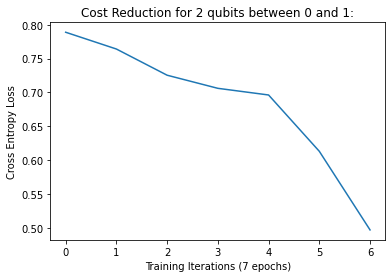

tot loss type is:  <class 'list'>
Begin eval for samples 0 and 1:
Performance on test data:
	Loss: 0.5972
	Accuracy: 57.2%
Evaluation time is:  0.029433937867482503  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 0 and 2:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.5849
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.5379
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.4960
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.4223
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.3700
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.2803
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.1998
Training runtime is:  2.1358716249465943 

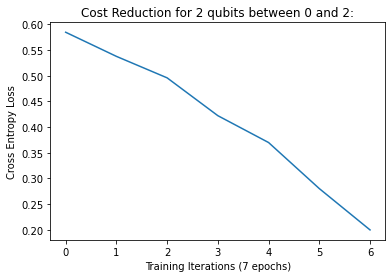

tot loss type is:  <class 'list'>
Begin eval for samples 0 and 2:
Performance on test data:
	Loss: 0.1746
	Accuracy: 98.9%
Evaluation time is:  0.02782698074976603  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 0 and 3:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.1952
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.1324
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.1108
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0809
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0690
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0664
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0615
Training runtime is:  2.0755120873451234  

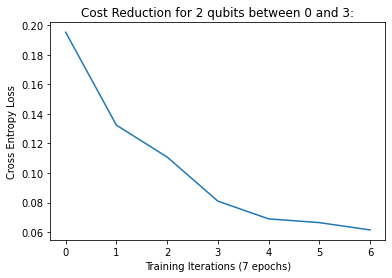

tot loss type is:  <class 'list'>
Begin eval for samples 0 and 3:
Performance on test data:
	Loss: 0.0521
	Accuracy: 100.0%
Evaluation time is:  0.03086032470067342  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 0 and 4:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.1180
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0749
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0551
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0359
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0402
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0313
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0268
Training runtime is:  2.073496226469676  

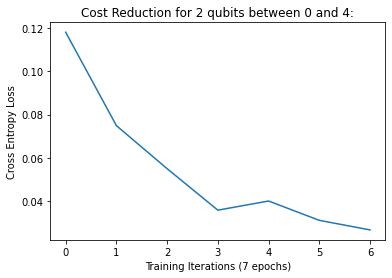

tot loss type is:  <class 'list'>
Begin eval for samples 0 and 4:
Performance on test data:
	Loss: 0.0248
	Accuracy: 100.0%
Evaluation time is:  0.027712734540303548  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 0 and 5:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.1649
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0893
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0515
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0313
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0300
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0200
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0166
Training runtime is:  2.0654108126958213

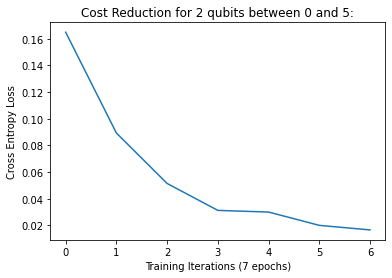

tot loss type is:  <class 'list'>
Begin eval for samples 0 and 5:
Performance on test data:
	Loss: 0.0147
	Accuracy: 100.0%
Evaluation time is:  0.02997114658355713  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 0 and 6:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.1667
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.1290
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.1534
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0909
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0736
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0596
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0357
Training runtime is:  2.0595101555188497 

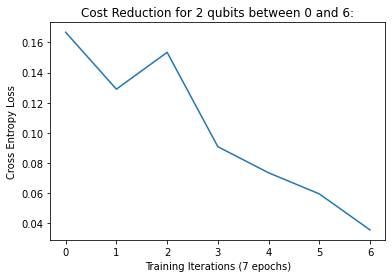

tot loss type is:  <class 'list'>
Begin eval for samples 0 and 6:
Performance on test data:
	Loss: 0.0293
	Accuracy: 100.0%
Evaluation time is:  0.029584709803263345  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 0 and 7:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.1086
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0911
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0750
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0418
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0320
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0152
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0320
Training runtime is:  2.0681631644566854

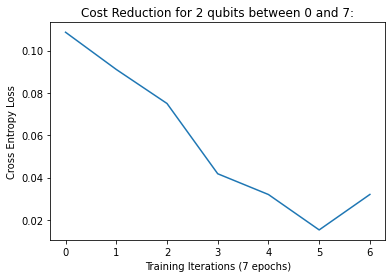

tot loss type is:  <class 'list'>
Begin eval for samples 0 and 7:
Performance on test data:
	Loss: 0.0209
	Accuracy: 100.0%
Evaluation time is:  0.027039583524068198  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 0 and 8:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.1021
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0284
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0225
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0221
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0129
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0224
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0072
Training runtime is:  2.050457465648651 

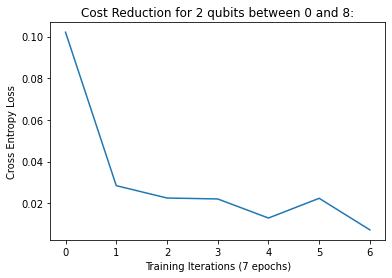

tot loss type is:  <class 'list'>
Begin eval for samples 0 and 8:
Performance on test data:
	Loss: 0.0063
	Accuracy: 100.0%
Evaluation time is:  0.02752366065979004  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 0 and 9:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.0144
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0124
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0135
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0072
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0188
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0060
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0039
Training runtime is:  2.0452728112538656 

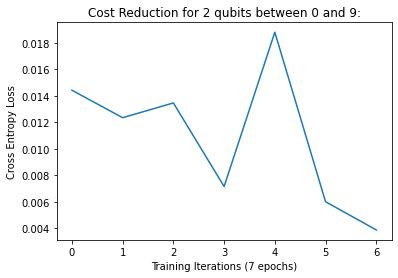

tot loss type is:  <class 'list'>
Begin eval for samples 0 and 9:
Performance on test data:
	Loss: 0.0036
	Accuracy: 100.0%
Evaluation time is:  0.026914230982462563  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 1 and 2:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.5083
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.1152
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0899
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0443
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0487
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0513
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0278
Training runtime is:  2.0453850269317626

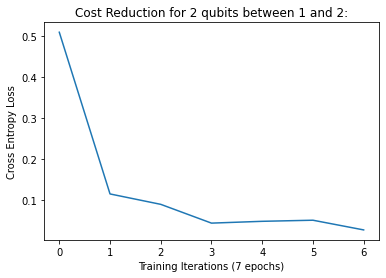

tot loss type is:  <class 'list'>
Begin eval for samples 1 and 2:
Performance on test data:
	Loss: 0.0178
	Accuracy: 100.0%
Evaluation time is:  0.026523220539093017  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 1 and 3:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.0536
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0347
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0178
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0462
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0270
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0406
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0352
Training runtime is:  2.0460105419158934

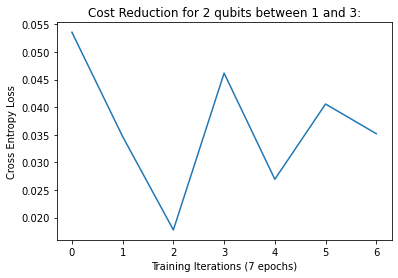

tot loss type is:  <class 'list'>
Begin eval for samples 1 and 3:
Performance on test data:
	Loss: 0.0211
	Accuracy: 100.0%
Evaluation time is:  0.02958288590113322  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 1 and 4:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.1688
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0514
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0483
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0651
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0364
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0164
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0192
Training runtime is:  2.042343620459239  

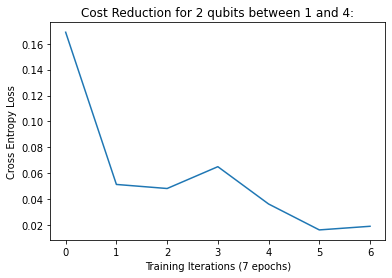

tot loss type is:  <class 'list'>
Begin eval for samples 1 and 4:
Performance on test data:
	Loss: 0.0129
	Accuracy: 100.0%
Evaluation time is:  0.027238126595815024  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 1 and 5:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.0446
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0341
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0141
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0151
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0392
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0112
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0070
Training runtime is:  2.039820063114166 

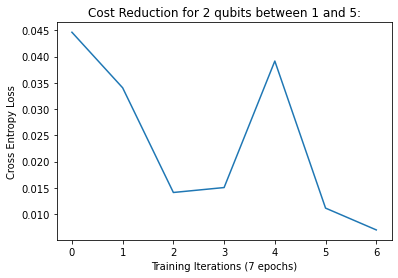

tot loss type is:  <class 'list'>
Begin eval for samples 1 and 5:
Performance on test data:
	Loss: 0.0052
	Accuracy: 100.0%
Evaluation time is:  0.02696413596471151  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 1 and 6:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.0130
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0032
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0029
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0053
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0128
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0024
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0035
Training runtime is:  2.051118834813436  

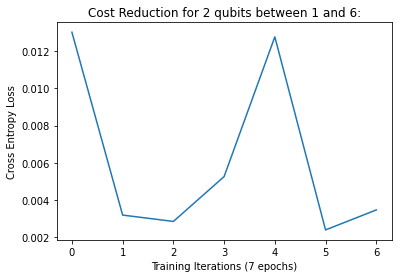

tot loss type is:  <class 'list'>
Begin eval for samples 1 and 6:
Performance on test data:
	Loss: 0.0029
	Accuracy: 100.0%
Evaluation time is:  0.02742666006088257  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 1 and 7:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.0342
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0219
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0175
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0050
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0105
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0028
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0328
Training runtime is:  2.049137512842814  

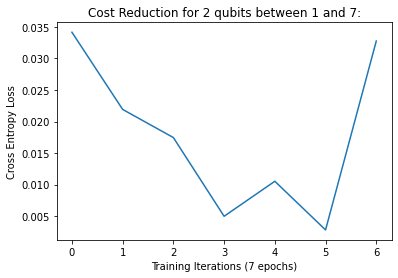

tot loss type is:  <class 'list'>
Begin eval for samples 1 and 7:
Performance on test data:
	Loss: 0.0179
	Accuracy: 100.0%
Evaluation time is:  0.026944923400878906  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 1 and 8:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.0674
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0295
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0789
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0179
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0040
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0031
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0210
Training runtime is:  2.0487327933311463

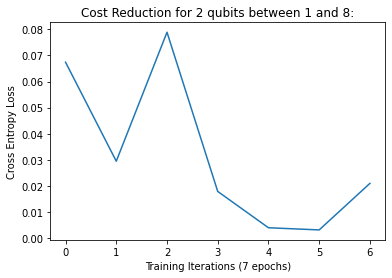

tot loss type is:  <class 'list'>
Begin eval for samples 1 and 8:
Performance on test data:
	Loss: 0.0136
	Accuracy: 100.0%
Evaluation time is:  0.027098047733306884  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 1 and 9:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.0155
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0723
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0262
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0492
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0145
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0033
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0253
Training runtime is:  2.0776623566945394

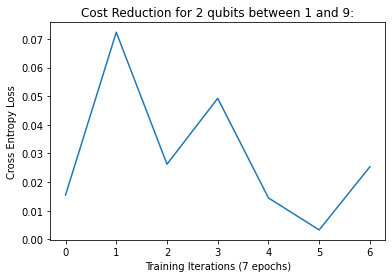

tot loss type is:  <class 'list'>
Begin eval for samples 1 and 9:
Performance on test data:
	Loss: 0.0146
	Accuracy: 100.0%
Evaluation time is:  0.026277931531270345  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 2 and 3:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.7140
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.2983
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.1832
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.2195
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.1628
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.1111
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.1631
Training runtime is:  2.0398255904515583

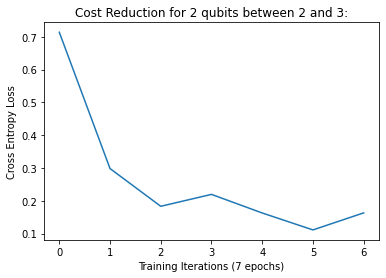

tot loss type is:  <class 'list'>
Begin eval for samples 2 and 3:
Performance on test data:
	Loss: 0.0950
	Accuracy: 100.0%
Evaluation time is:  0.027086702982584636  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 2 and 4:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.2098
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0635
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0557
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0291
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0887
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0340
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0140
Training runtime is:  2.036232284704844 

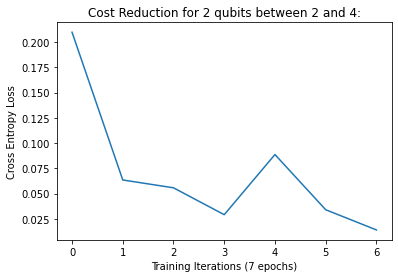

tot loss type is:  <class 'list'>
Begin eval for samples 2 and 4:
Performance on test data:
	Loss: 0.0101
	Accuracy: 100.0%
Evaluation time is:  0.026571222146352134  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 2 and 5:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.1120
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0332
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0240
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0464
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0345
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0105
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0166
Training runtime is:  2.0505221207936604

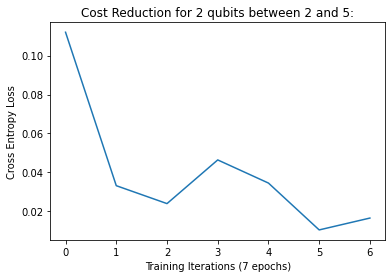

tot loss type is:  <class 'list'>
Begin eval for samples 2 and 5:
Performance on test data:
	Loss: 0.0100
	Accuracy: 100.0%
Evaluation time is:  0.02726854880650838  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 2 and 6:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.0441
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0219
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0154
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0278
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0767
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0279
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0093
Training runtime is:  2.038487696647644  

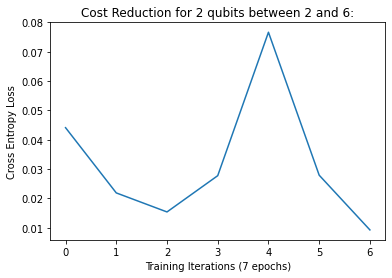

tot loss type is:  <class 'list'>
Begin eval for samples 2 and 6:
Performance on test data:
	Loss: 0.0061
	Accuracy: 100.0%
Evaluation time is:  0.026354459921518962  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 2 and 7:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.2453
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0719
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.1008
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0995
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0936
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.1100
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0394
Training runtime is:  2.037297828992208 

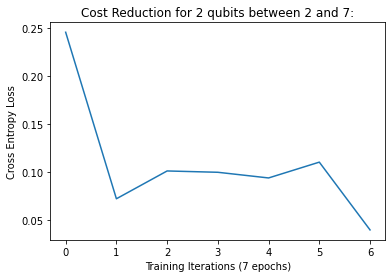

tot loss type is:  <class 'list'>
Begin eval for samples 2 and 7:
Performance on test data:
	Loss: 0.0278
	Accuracy: 100.0%
Evaluation time is:  0.026396016279856365  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 2 and 8:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.2503
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0700
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.1093
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0203
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0549
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0283
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0553
Training runtime is:  2.0261745969454448

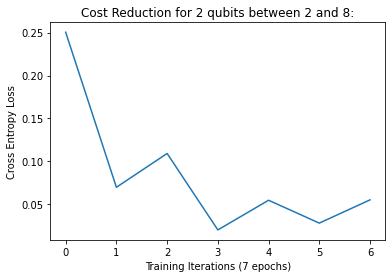

tot loss type is:  <class 'list'>
Begin eval for samples 2 and 8:
Performance on test data:
	Loss: 0.0312
	Accuracy: 100.0%
Evaluation time is:  0.02696038087209066  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 2 and 9:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.0638
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0133
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0159
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0311
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0133
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0056
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0111
Training runtime is:  2.025315789381663  

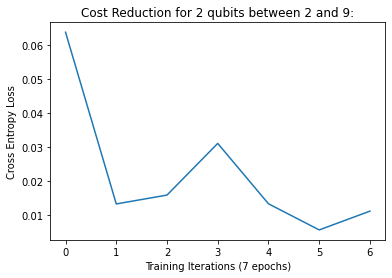

tot loss type is:  <class 'list'>
Begin eval for samples 2 and 9:
Performance on test data:
	Loss: 0.0064
	Accuracy: 100.0%
Evaluation time is:  0.026458024978637695  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 3 and 4:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.3093
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0901
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0502
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0283
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0346
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0200
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0082
Training runtime is:  2.024192814032237 

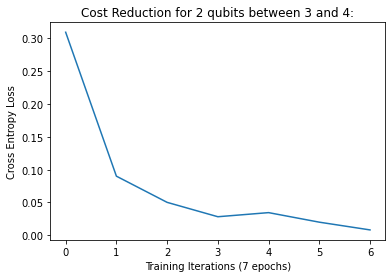

tot loss type is:  <class 'list'>
Begin eval for samples 3 and 4:
Performance on test data:
	Loss: 0.0050
	Accuracy: 100.0%
Evaluation time is:  0.026343890031178794  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 3 and 5:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.2866
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.2293
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.1171
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0662
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0658
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0892
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0534
Training runtime is:  2.0333020726839703

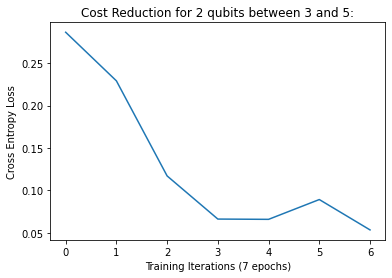

tot loss type is:  <class 'list'>
Begin eval for samples 3 and 5:
Performance on test data:
	Loss: 0.0367
	Accuracy: 99.4%
Evaluation time is:  0.027233401934305828  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 3 and 6:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.0520
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0207
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0310
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0084
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0112
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0076
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0055
Training runtime is:  2.036057202021281  

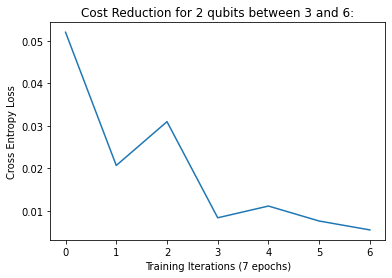

tot loss type is:  <class 'list'>
Begin eval for samples 3 and 6:
Performance on test data:
	Loss: 0.0039
	Accuracy: 100.0%
Evaluation time is:  0.027136568228403726  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 3 and 7:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.4043
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.1724
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0956
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0454
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0610
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0525
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0702
Training runtime is:  2.035575199127197 

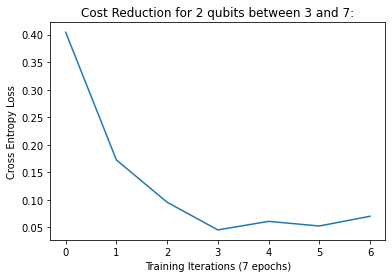

tot loss type is:  <class 'list'>
Begin eval for samples 3 and 7:
Performance on test data:
	Loss: 0.0435
	Accuracy: 100.0%
Evaluation time is:  0.027030523618062338  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 3 and 8:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.2077
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0835
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.1361
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0912
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0458
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0369
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0290
Training runtime is:  2.035059436162313 

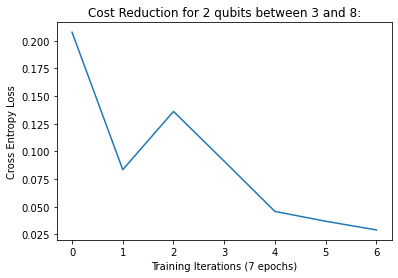

tot loss type is:  <class 'list'>
Begin eval for samples 3 and 8:
Performance on test data:
	Loss: 0.0203
	Accuracy: 100.0%
Evaluation time is:  0.026818613211313885  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 3 and 9:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.0889
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0348
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0134
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0125
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0083
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0092
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0055
Training runtime is:  2.0311402797698976

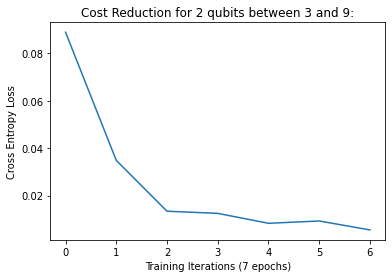

tot loss type is:  <class 'list'>
Begin eval for samples 3 and 9:
Performance on test data:
	Loss: 0.0036
	Accuracy: 100.0%
Evaluation time is:  0.02692413330078125  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 4 and 5:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 1.7298
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 1.6668
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 1.3258
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.9259
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.8443
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.6455
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.4683
Training runtime is:  2.0288711547851563 

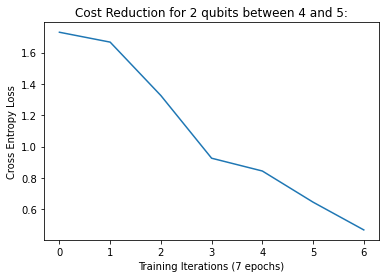

tot loss type is:  <class 'list'>
Begin eval for samples 4 and 5:
Performance on test data:
	Loss: 0.3753
	Accuracy: 87.2%
Evaluation time is:  0.026665095488230386  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 4 and 6:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.7784
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.4410
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.2560
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.2261
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.1012
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.1423
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.1299
Training runtime is:  2.036862675348918  

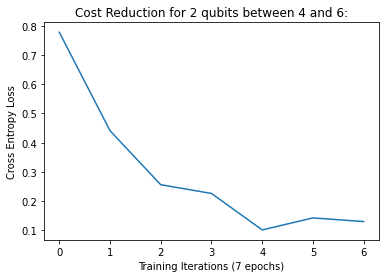

tot loss type is:  <class 'list'>
Begin eval for samples 4 and 6:
Performance on test data:
	Loss: 0.0947
	Accuracy: 99.4%
Evaluation time is:  0.0278857429822286  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 4 and 7:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.4396
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.2375
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.1485
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.1240
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0808
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.1102
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0644
Training runtime is:  2.0515328963597614  m

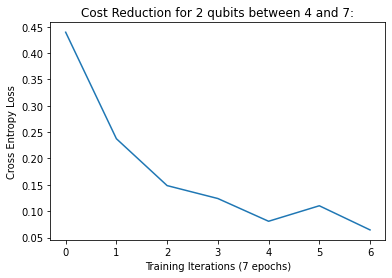

tot loss type is:  <class 'list'>
Begin eval for samples 4 and 7:
Performance on test data:
	Loss: 0.0653
	Accuracy: 98.9%
Evaluation time is:  0.027322045962015786  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 4 and 8:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.1238
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.1445
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.1056
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0710
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0563
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0829
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0700
Training runtime is:  2.0263756195704143 

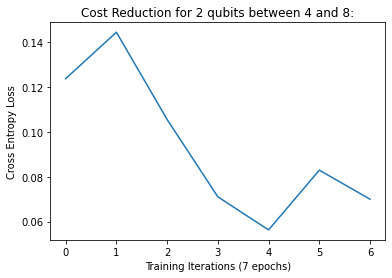

tot loss type is:  <class 'list'>
Begin eval for samples 4 and 8:
Performance on test data:
	Loss: 0.0614
	Accuracy: 98.9%
Evaluation time is:  0.027137263615926107  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 4 and 9:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.3423
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.2395
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.1442
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.1757
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.1407
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.1274
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0829
Training runtime is:  2.0002819617589314 

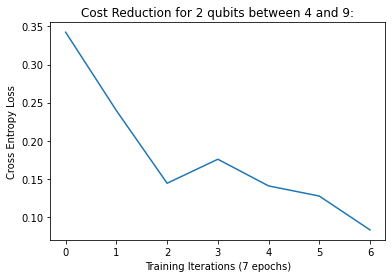

tot loss type is:  <class 'list'>
Begin eval for samples 4 and 9:
Performance on test data:
	Loss: 0.0737
	Accuracy: 98.9%
Evaluation time is:  0.026901880900065105  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 5 and 6:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.8206
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.1945
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.1262
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0732
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0905
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.1512
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0603
Training runtime is:  2.007535378138224  

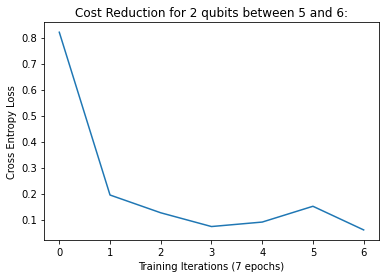

tot loss type is:  <class 'list'>
Begin eval for samples 5 and 6:
Performance on test data:
	Loss: 0.0421
	Accuracy: 99.4%
Evaluation time is:  0.027166342735290526  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 5 and 7:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.6073
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.2906
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.1771
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.1393
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.1438
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0730
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0773
Training runtime is:  1.9992424766222636 

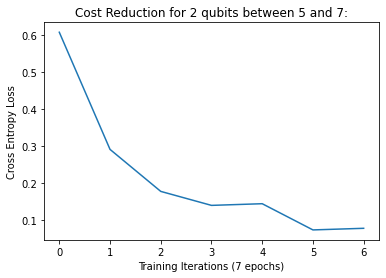

tot loss type is:  <class 'list'>
Begin eval for samples 5 and 7:
Performance on test data:
	Loss: 0.0529
	Accuracy: 100.0%
Evaluation time is:  0.026846365133921305  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 5 and 8:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.3035
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.1869
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.1512
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.1401
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.1055
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.1161
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0941
Training runtime is:  1.9958080093065897

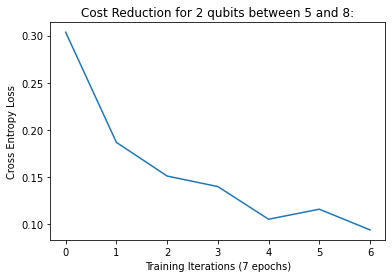

tot loss type is:  <class 'list'>
Begin eval for samples 5 and 8:
Performance on test data:
	Loss: 0.0607
	Accuracy: 100.0%
Evaluation time is:  0.02928216060002645  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 5 and 9:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.3221
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.2390
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.2269
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.1441
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.1315
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.1563
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0858
Training runtime is:  1.9803542455037435 

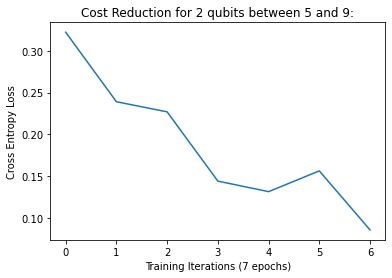

tot loss type is:  <class 'list'>
Begin eval for samples 5 and 9:
Performance on test data:
	Loss: 0.0754
	Accuracy: 97.8%
Evaluation time is:  0.02722528378168742  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 6 and 7:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.2098
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0288
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0288
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0232
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0265
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0187
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0274
Training runtime is:  1.981846539179484  m

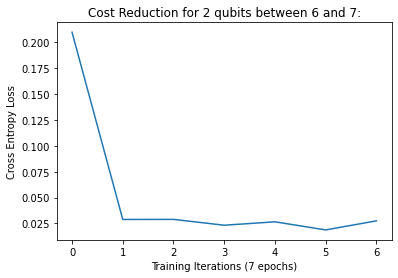

tot loss type is:  <class 'list'>
Begin eval for samples 6 and 7:
Performance on test data:
	Loss: 0.0161
	Accuracy: 100.0%
Evaluation time is:  0.0283937931060791  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 6 and 8:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.1401
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0832
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0838
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0818
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0521
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0596
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0468
Training runtime is:  1.9685064633687337  

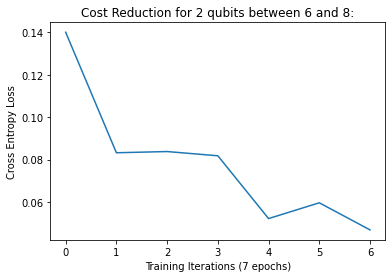

tot loss type is:  <class 'list'>
Begin eval for samples 6 and 8:
Performance on test data:
	Loss: 0.0269
	Accuracy: 100.0%
Evaluation time is:  0.029055066903432212  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 6 and 9:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.0254
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.0208
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.0131
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.0347
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0289
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0142
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0187
Training runtime is:  1.9757801095644634

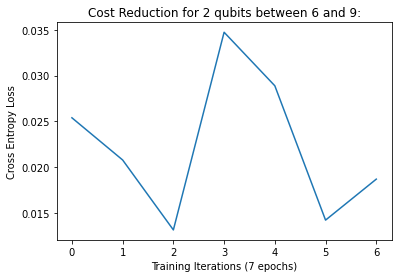

tot loss type is:  <class 'list'>
Begin eval for samples 6 and 9:
Performance on test data:
	Loss: 0.0110
	Accuracy: 100.0%
Evaluation time is:  0.0292001207669576  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 7 and 8:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.8519
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.4346
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.2723
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.1653
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.2030
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.1435
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.1057
Training runtime is:  1.971308179696401  m

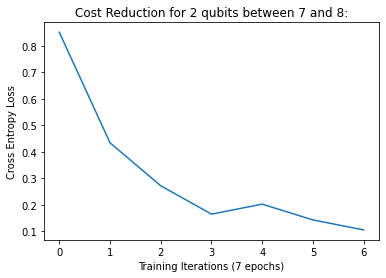

tot loss type is:  <class 'list'>
Begin eval for samples 7 and 8:
Performance on test data:
	Loss: 0.0673
	Accuracy: 99.4%
Evaluation time is:  0.029464594523111978  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 7 and 9:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.3151
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.1710
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.1265
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.1348
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0575
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.1042
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0596
Training runtime is:  1.9934234460194906 

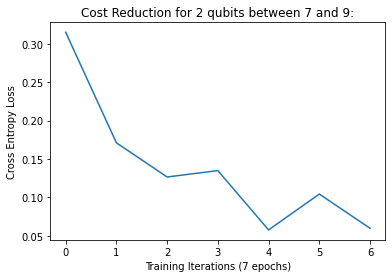

tot loss type is:  <class 'list'>
Begin eval for samples 7 and 9:
Performance on test data:
	Loss: 0.0445
	Accuracy: 98.9%
Evaluation time is:  0.02933513323465983  min
model is:  <class '__main__.Net'>
optim is:  <class 'torch.optim.adam.Adam'>
loss func is:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
test load is:  <class 'torch.utils.data.dataloader.DataLoader'>
type of i is:  <class 'int'>
type of j is:  <class 'int'>
type of epoch is:  <class 'int'>

Begin training for samples 8 and 9:
Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.6600
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.2567
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.2303
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.1914
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.1764
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0925
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.1335
Training runtime is:  1.9984083294868469  

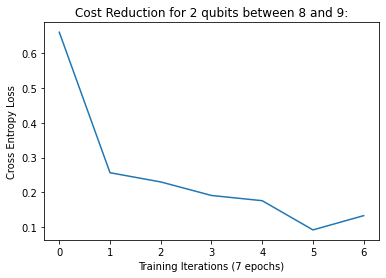

tot loss type is:  <class 'list'>
Begin eval for samples 8 and 9:
Performance on test data:
	Loss: 0.0915
	Accuracy: 98.9%
Evaluation time is:  0.02718716859817505  min
Total program runtime is:  93.0210084438324  min


In [ ]:
# total program runtime
start_eval = time.time()

acc_vals = []

# main program loop I guess?
for i in data_set:
    # want to exclude 9 to avoid repeats
    if i != 9:
        # iterate through indices larger than i to create subset
        for j in data_set:
            if j > i:
                subset = [i, j]

                # load a subset of data for training
                trn_load = load_training(i, j, 210)
                # load subset for testing
                tst_load = load_testing(i, j, 90)

                ### DEBUG
                print("model is: ", type(model))
                print("optim is: ", type(optimizer))
                print("loss func is: ", type(loss_func))
                print("test load is: ", type(tst_load))
                print("type of i is: ", type(i))
                print("type of j is: ", type(j))
                print("type of epoch is: ", type(epochs))

                # start training for subset
                if gpu:
                    tot_loss = perform_training_gpu(model, optimizer, loss_func, tst_load, i, j, epochs)
                else:
                    tot_loss = perform_training(model, optimizer, loss_func, tst_load, i, j, epochs)

                ### DEBUG
                print("tot loss type is: ", type(tot_loss))

                # then evaluate model for subset
                if gpu:
                    perform_eval_gpu(model, loss_func, tst_load, tot_loss, i, j)
                else:
                    perform_eval(model, loss_func, tst_load, tot_loss, i, j)

                # add a data structure to hold the accuracy values for each set of elements



# end eval time
end_eval = time.time()
print('Total program runtime is: ', (end_eval - start_eval)/60, ' min')